In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_heart = pd.read_csv('framingham_heart_disease.csv')

**1. אמידה**

א - ממוצע של רמת הגלוקוז בקרב מעשנים לעומת לא מעשנים


In [ ]:
relevant_features = ['currentSmoker', 'glucose']
df = df_heart[relevant_features]
print(df)
means = df.groupby('currentSmoker')['glucose'].mean()
print(means)

      currentSmoker  glucose
0                 0     77.0
1                 0     76.0
2                 1     70.0
3                 1    103.0
4                 1     85.0
...             ...      ...
4233              1     86.0
4234              1     68.0
4235              1     86.0
4236              1      NaN
4237              0    107.0

[4238 rows x 2 columns]
currentSmoker
0    83.302907
1    80.579672
Name: glucose, dtype: float64


ב - רווחי סמך

In [ ]:
import numpy as np
import scipy.stats as st

non_smoker = df[df['currentSmoker']== 0]
smoker = df[df['currentSmoker'] == 1]
non_smoker=non_smoker.dropna()
smoker=smoker.dropna()
smoker_data = list(smoker['glucose'])
non_smoker_data = list(non_smoker['glucose'])

def ci (df, to_print=True):
  non_smoker = df[df['currentSmoker']== 0]
  smoker = df[df['currentSmoker'] == 1]
  non_smoker=non_smoker.dropna()
  smoker=smoker.dropna()
  smoker_data = list(smoker['glucose'])
  non_smoker_data = list(non_smoker['glucose'])
  non_smoker_ci = st.t.interval(alpha=0.95, df=len(non_smoker_data)-1, loc=np.mean(non_smoker_data), scale=st.sem(non_smoker_data)) 
  smoker_ci = st.t.interval(alpha=0.95, df=len(smoker_data)-1, loc=np.mean(smoker_data), scale=st.sem(smoker_data))
  if (to_print):
    print("Non Smoker CI ")
    print("average is:" ,np.mean(non_smoker_data)," and CI is: ", non_smoker_ci)
    print("Smoker CI ")
    print("average is:" ,np.mean(smoker_data)," and CI is: ", smoker_ci)
  return non_smoker_ci, smoker_ci

In [ ]:
ci = ci(df, to_print=True)
print()

Non Smoker CI 
average is: 83.30290668026517  and CI is:  (82.15527490108059, 84.45053845944975)
Smoker CI 
average is: 80.5796717840127  and CI is:  (79.60195560880419, 81.55738795922122)



רווחי הסמך אינם חופפים ולכן ניתן להסיק שהתוחלת עבור האכלוסיות היא שונה ברמת בטחון של 95%

---



**2. מבחני השערות**

א. השערת האפס - אין הבדל בתוחלת רמת הגלוקוז בקרב מעשנים לעומת לא מעשנים.
השערה אלטרנטיבית - יש הבדל.

ב. הנחת הנורמליות לא מתקיימת ולכן לא ניתן להסתמך על מבחן טי
ניתן לראות זאת בהיסטוגרמה הבאה וגם בהשוואת השברונים בqqplot

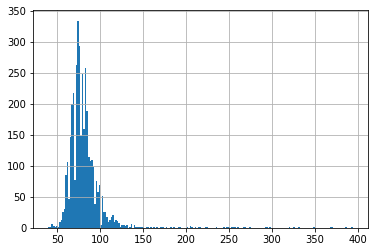

In [ ]:
df_glu = df["glucose"].dropna()
df_glu.hist(bins=200)


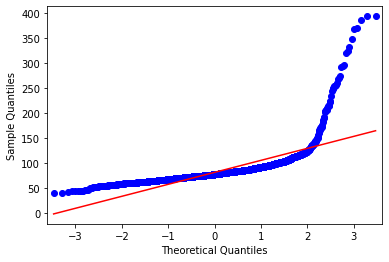

In [ ]:
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50
# q-q plot
qqplot(df_glu, line='s')
pyplot.show()

ד. מבחן וואלד

In [ ]:
#WALD TEST
def wald_test(smoker_data, non_smoker_data):
  smoker_miu_hat = np.mean(smoker_data)
  non_smoker_miu_hat = np.mean(non_smoker_data)
  delta_hat = smoker_miu_hat - non_smoker_miu_hat

  smoker_se_hat = st.sem(smoker_data)
  non_smoker_se_hat = st.sem(non_smoker_data)

  smoker_len = len(smoker_data)
  non_smoker_len = len(non_smoker_data)

  wald_statisty = delta_hat/(smoker_se_hat**2/smoker_len +non_smoker_se_hat**2/non_smoker_len)**0.5

  if abs(wald_statisty)> 1.96:
    return "reject", "wald statisty is:", wald_statisty
  return "do not rject", "wald statisty is:", wald_statisty

wald_res = wald_test(smoker_data, non_smoker_data)
print(wald_res)

('reject', 'wald statisty is:', -155.62984838908187)


ה. 

ניתן לראות ש
p-value

מאוד קטן, וזה בהחלט מסתדר עם הציפייה.


In [ ]:
from scipy import stats
def pvalue(x, y):
  x = np.array(x)
  y = np.array(y)
  x_bar, y_bar = x.mean(), y.mean()
  x_se, y_se = x.std(), y.std()
  n, m = len(x), len(y)

  T = (x_bar - y_bar) / np.sqrt((((x_se**2 / n)) + (y_se**2 / m)))
  return 2 * stats.norm.pdf(-abs(T))

In [ ]:
print("p-value is: ",pvalue(smoker_data,non_smoker_data))

p-value is:  0.001498004632214346


ו.

נשוה למודל של התפלגות נורמלית.


likelihood ratio:
h0- התוחלות שוות
h1- התוחלות שונות
זהו ממבחן דו צדדי.
סטטיסי המבחן:

${T.S.:\left(\frac{\bar{X}-\bar{Y}}{\sqrt{\sigma^{2}\left(\frac{1}{n}+\frac{1}{m}\right)}}\right)^{2}}$

$R.R: T > \chi^2_{1},{\alpha}$

In [ ]:
from scipy import stats
def log_likelihood_ratio_test(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    s = (x1.std()**2)*(1 / len(x1) + 1 /len(x2))
    x_bar = x1.mean()- x2.mean()
    z_sq = (x_bar/(s)**0.5)**2 # chisq(1)  
    c = stats.chi2.ppf(0.95,1)
   
    if z_sq > c:
        print("Reject H0")
    else:
        print("Don't reject H0")

In [ ]:
log_likelihood_ratio_test(smoker_data, non_smoker_data)

Reject H0


שאלה 3

In [ ]:
def ci_for3 (smoker_data, non_smoker_data, to_print=True):
  non_smoker_ci = st.t.interval(alpha=0.95, df=len(non_smoker_data)-1, loc=np.mean(non_smoker_data), scale=st.sem(non_smoker_data)) 
  smoker_ci = st.t.interval(alpha=0.95, df=len(smoker_data)-1, loc=np.mean(smoker_data), scale=st.sem(smoker_data))
  if (to_print):
    print("Non Smoker CI ")
    print("average is:" ,np.mean(non_smoker_data)," and CI is: ", non_smoker_ci)
    print("Smoker CI ")
    print("average is:" ,np.mean(smoker_data)," and CI is: ", smoker_ci)
  return non_smoker_ci, smoker_ci

In [ ]:
#general function to implement the split
def sample_and_split(df, n):
  df = df.sample(n=n)
  non_smoker = df[df['currentSmoker']== 0]
  smoker = df[df['currentSmoker'] == 1]
  non_smoker=non_smoker.dropna()
  smoker=smoker.dropna()
  smoker_data = list(smoker['glucose'])
  non_smoker_data = list(non_smoker['glucose'])
  return(smoker_data, non_smoker_data)

In [ ]:
sizes = [30, 50, 100, 500]

for n in sizes:
  print("sample size: " + str(n))
  smoker, non_smoker = sample_and_split(df,n)
  smoker_ci, non_smoker_ci = ci_for3(smoker, non_smoker)
  print("Smoker CI: " + str(smoker_ci))
  print("Non smoker CI: " + str(non_smoker_ci))
  print("")

sample size: 30
Non Smoker CI 
average is: 84.8  and CI is:  (77.12642856728321, 92.47357143271678)
Smoker CI 
average is: 87.15789473684211  and CI is:  (76.88652926796524, 97.42926020571898)
Smoker CI: (77.12642856728321, 92.47357143271678)
Non smoker CI: (76.88652926796524, 97.42926020571898)

sample size: 50
Non Smoker CI 
average is: 81.77777777777777  and CI is:  (72.5283796459384, 91.02717590961714)
Smoker CI 
average is: 88.35714285714286  and CI is:  (69.43277903295554, 107.28150668133019)
Smoker CI: (72.5283796459384, 91.02717590961714)
Non smoker CI: (69.43277903295554, 107.28150668133019)

sample size: 100
Non Smoker CI 
average is: 81.23076923076923  and CI is:  (77.4184502296965, 85.04308823184195)
Smoker CI 
average is: 84.14634146341463  and CI is:  (76.76060563148903, 91.53207729534023)
Smoker CI: (77.4184502296965, 85.04308823184195)
Non smoker CI: (76.76060563148903, 91.53207729534023)

sample size: 500
Non Smoker CI 
average is: 85.50597609561753  and CI is:  (82.50

אם נשווה את רווחי הסמך המקורבים שמצאנו לרווחי הסמך בשאלה 1 נוכל לראות שגודל הרווח הוא פונקציה שתלויה בגודל המדגם בהתאם למה שהוכחנו בכיתה. בנוסף נוכל גם לראות שהמיקום של הרווח משתנה כתלות בגודל המדגם כאשר הוא שואף לתוצאות בשאלה 1 כאשר הם שואפות לתוחלת ה"אמיתית" של הנתונים.

In [ ]:
def wald_3(x, y, alpha):
  x= np.array(x)
  y= np.array(y)
  x_bar = x.mean()
  y_bar = y.mean()
  x_se = x.std()
  y_se = y.std()
  n = len(x)
  m = len(y)
  T = (x_bar - y_bar) / np.sqrt((((x_se**2 / n)) + (y_se**2 / m)))
  quantile_alpha = stats.norm.ppf(1 - (alpha / 2))
  print("Test statistic is " + str(T)) 
  if abs(T) > quantile_alpha:
    print("Reject H0")
  else:
    print("Don't rejecrt H0")

אנחנו רואים שלא תמיד לכל המדגמים אנחנו דוחים את השערת הבסיס גם בגלל השונות וגם בגלל הצד הרנדומלי של הגרלת המדגם. אך באופן כללי ככל שהמדגם גדול יותר תקטן ההשפעה של המדגם הספציפי ונשאף לתוצאה משאלה 2

In [ ]:
for n in sizes:
  print("sample = " + str(n))
  smoker, non_smoker = sample_and_split(df,n)
  print(wald_test(smoker, non_smoker))
  print("")

sample = 30
('do not rject', 'wald statisty is:', -1.8976515911812426)

sample = 50
('do not rject', 'wald statisty is:', 0.7820958545147092)

sample = 100
('reject', 'wald statisty is:', 10.63861683406615)

sample = 500
('reject', 'wald statisty is:', 9.069731584626542)



In [ ]:
# for n in sizes:
#   print("sample = " + str(n))
#   smoker, non_smoker = sample_and_split(df,n)
#   wald_3(smoker, non_smoker, 0.05)
#   print("")

סעיף ד: ניתן לראות שגן אורך רווחי הסמך וגם הערך ה
p value
יורד ככל שגודל המדגם גדל.
בנוסף אפשר גם לראות שככל שהמדגם גדל כך גם הפרופורציות שהממוצע בתוך הרווח סמך גם גדלה וגם זאת כמובן תוצאה שציפינו לה.

In [ ]:
def sample_size_vis(data, title, y_label, name=None):
  x = list(data.keys())
  y = list(data.values())
  fig = sns.lineplot(x=x, y=y, marker='o')
  fig.set(title = title, xlabel = 'Sample Size', ylabel = y_label)
  plt.legend(labels=name)

In [ ]:
from scipy import stats
def pvalue(x, y):
  x = np.array(x)
  y = np.array(y)
  x_bar, y_bar = x.mean(), y.mean()
  x_se, y_se = x.std(), y.std()
  n, m = len(x), len(y)

  T = (x_bar - y_bar) / np.sqrt((((x_se**2 / n)) + (y_se**2 / m)))
  return 2 * stats.norm.pdf(-abs(T))

In [ ]:
smoker_results_lens, smoker_results_prop, = {}, {}
non_smoker_results_lens, non_smoker_results_prop = {}, {}
results_pvalue = {}


for n in sizes:
  smoker_ci_lens, non_smoker_ci_lens = [], []
  smoker_prop, non_smoker_prop = [], []
  pvalues = []
  for i in range(100):
    smoker,non_smoker = sample_and_split(df,n)

    non_smoker_ci, smoker_ci = ci_for3(smoker, non_smoker, to_print=False)
    # print(smoker_ci)
    smoker_ci_lens.append(smoker_ci[1] - smoker_ci[0])
    smoker_prop.append(smoker_ci[0] < 80.5 < smoker_ci[1]) #mean of smokers

    non_smoker_ci_lens.append(non_smoker_ci[1] - non_smoker_ci[0])
    non_smoker_prop.append(non_smoker_ci[0] < 83.3 < non_smoker_ci[1]) #mean of non smokers
    #pvalue
    pvalues.append(pvalue(smoker,non_smoker)) 

  smoker_results_lens[n] = sum(smoker_ci_lens) / len(smoker_ci_lens)
  smoker_results_prop[n] = sum(smoker_prop) / len(smoker_prop)

  non_smoker_results_lens[n] = sum(non_smoker_ci_lens) / len(non_smoker_ci_lens)
  non_smoker_results_prop[n] = sum(non_smoker_prop) / len(non_smoker_prop)

  results_pvalue[n] = sum(pvalues) / len(pvalues)




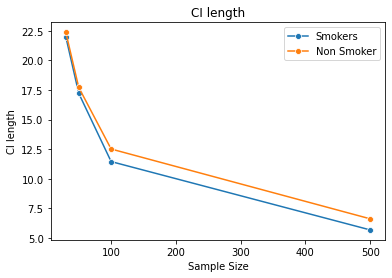

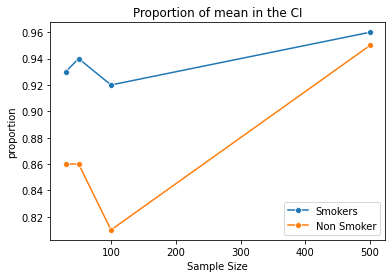

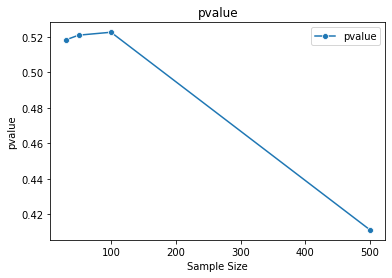

In [ ]:
ci_lens = pd.DataFrame([smoker_results_lens, non_smoker_results_lens])
names = ["Smokers", "Non Smoker"]

sample_size_vis(smoker_results_lens, "CI length", "CI length", names)
sample_size_vis(non_smoker_results_lens, "CI length", "CI length", names)
plt.show()

sample_size_vis(smoker_results_prop, "Proportion of mean in the CI", "proportion", names)
sample_size_vis(non_smoker_results_prop, "Proportion of mean in the CI", "proportion", names)
plt.show()

sample_size_vis(results_pvalue, "pvalue", "pvalue", ['pvalue'])
plt.show()